In [24]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
#psi4.core.set_output_file('output.dat', False)
import time
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from numpy.polynomial import Chebyshev


In [ ]:
min_length = 1.0  # Minimum bond length
max_length = 2.2  # Maximum bond length

# Define the equilibrium bond length
equilibrium_length = 1.5500000000000003  # Adjust as needed

# Specify the number of data points you want near the equilibrium bond length
num_points_near_equilibrium = 25

# Specify the number of data points in the remaining range
num_points_remaining = 25

# Create a non-uniform grid
grid_near_equilibrium = np.linspace(equilibrium_length - 0.5, equilibrium_length + 0.5, num_points_near_equilibrium)
grid_remaining = np.linspace(min_length, max_length, num_points_remaining)

# Combine the grids to create the non-uniform grid
r_array = np.sort(np.concatenate((grid_near_equilibrium, grid_remaining)))
print(r_array)

In [2]:
def chebyshev_nodes(n):
    return 0.5 * (1.0 - np.cos(np.pi * (2.0 * np.arange(1, n + 1) - 1) / (2.0 * n)))

def create_chebyshev_grid(start, end, num_points):
    nodes = chebyshev_nodes(num_points)
    scaled_nodes = start + nodes * (end - start)
    return scaled_nodes

r_array = create_chebyshev_grid(1, 3, 50)

print(r_array)


[1.00049344 1.00443804 1.01231166 1.02408324 1.03970631 1.05911923
 1.08224537 1.10899348 1.13925797 1.17291943 1.20984499 1.24988893
 1.29289322 1.33868813 1.38709295 1.43791662 1.49095858 1.5460095
 1.60285211 1.66126208 1.72100889 1.78185676 1.84356553 1.90589169
 1.96858924 2.03141076 2.09410831 2.15643447 2.21814324 2.27899111
 2.33873792 2.39714789 2.4539905  2.50904142 2.56208338 2.61290705
 2.66131187 2.70710678 2.75011107 2.79015501 2.82708057 2.86074203
 2.89100652 2.91775463 2.94088077 2.96029369 2.97591676 2.98768834
 2.99556196 2.99950656]


In [3]:
# setup basic arguments for qed-ci calculation

# z-matrix for LIH
mol_str_LiH = """
Li
H 1 1.8
symmetry c1
"""

# z-matrix ffor H2
mol_str_H2 = """
H
H 1 0.74
symmetry c1
"""

# options for Psi4
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.05]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}



In [4]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl_LiH = """
Li
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

#r_array = np.linspace(0.2, 2.2, N_R)


# array for energies for LiH outside cavity
cavity_free_E_array_LiH = np.zeros((N_R, N_el))

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_idx_LiH = 0
for r in r_array:
    mol_str_LiH = mol_tmpl_LiH.replace("**R**", str(r))
    mol_LiH = psi4.geometry(mol_str_LiH)
    print(mol_str_LiH)
    
    # call psi4 RHF
    scf_e, wfn_LiH = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_LiH = psi4.energy('fci/sto-3g',ref_wfn=wfn_LiH)
    
    # LiH no cavity
    LiH = PFHamiltonianGenerator(mol_str_LiH, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(LiH.CIeigs[0], fci_energy_LiH)
    
    # LiH with cavity
    LiH_cav = PFHamiltonianGenerator(mol_str_LiH, options_dict, cavity_dict)
    cavity_free_E_array_LiH[r_idx_LiH,:] = LiH.CIeigs[:N_el]
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1
    
    
    


Li
H 1 1.0004934396342684
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3096803341E-01.
  Reciprocal condition number of the overlap matrix is 1.2403718364E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7262511253356934 seconds

Li
H 1 1.00443803539692
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:40 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3132205892E-01.
  Reciprocal condition number of the overlap matrix is 1.2429596328E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7162590026855469 seconds

Li
H 1 1.0123116594048622
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:42 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3204358973E-01.
  Reciprocal condition number of the overlap matrix is 1.2482154313E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7282230854034424 seconds

Li
H 1 1.0240832380612526
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:44 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3315996472E-01.
  Reciprocal condition number of the overlap matrix is 1.2563027074E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.71858811378479 seconds

Li
H 1 1.039706314323057
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:45 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3471296985E-01.
  Reciprocal condition number of the overlap matrix is 1.2674734161E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7180740833282471 seconds

Li
H 1 1.0591192310457744
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:47 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.3675932405E-01.
  Reciprocal condition number of the overlap matrix is 1.2820736556E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6942951679229736 seconds

Li
H 1 1.082245374316019
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:49 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.50399183148086   -7.50399e+00   0.00000e+00 
   @RHF iter   1:    -7.79318506897885   -2.89193e-01   1.45359e-02 DIIS/ADIIS
   @RHF iter   2:    -7.80237850896268   -9.19344e-03   1.47902e-03 DIIS/ADIIS
   @RHF iter   3:    -7.80255499386500   -1.76485e-04   4.41622e-04 DIIS/ADIIS
   @RHF iter   4:    -7.80259120066321   -3.62068e-05   9.65750e-05 DIIS
   @RHF iter   5:    -7.80259294323705   -1.74257e-06   9.31446e-07 DIIS
   @RHF iter   6:    -7.80259294341047   -1.73428e-10   1.09824e-08 DIIS
   @RHF iter   7:    -7.80259294341048   -8.88178e-15   6.32149e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.693253755569458 seconds

Li
H 1 1.1089934758116322
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:51 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.49951391348697   -7.49951e+00   0.00000e+00 
   @RHF iter   1:    -7.80180544498203   -3.02292e-01   1.48461e-02 DIIS/ADIIS
   @RHF iter   2:    -7.81145560853307   -9.65016e-03   1.52220e-03 DIIS/ADIIS
   @RHF iter   3:    -7.81164419519697   -1.88587e-04   4.53555e-04 DIIS/ADIIS
   @RHF iter   4:    -7.81168265383778   -3.84586e-05   8.80586e-05 DIIS
   @RHF iter   5:    -7.81168407069458   -1.41686e-06   9.70488e-07 DIIS
   @RHF iter   6:    -7.81168407087650   -1.81914e-10   5.56503e-09 DIIS
   @RHF iter   7:    -7.81168407087651   -7.99361e-15   5.46846e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.693673849105835 seconds

Li
H 1 1.1392579729960564
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:52 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.49478713533218   -7.49479e+00   0.00000e+00 
   @RHF iter   1:    -7.81037425800137   -3.15587e-01   1.51791e-02 DIIS/ADIIS
   @RHF iter   2:    -7.82052681827463   -1.01526e-02   1.56767e-03 DIIS/ADIIS
   @RHF iter   3:    -7.82072857497828   -2.01757e-04   4.65789e-04 DIIS/ADIIS
   @RHF iter   4:    -7.82076942173650   -4.08468e-05   7.77504e-05 DIIS
   @RHF iter   5:    -7.82077049602199   -1.07429e-06   1.03716e-06 DIIS
   @RHF iter   6:    -7.82077049621427   -1.92280e-10   6.82918e-09 DIIS
   @RHF iter   7:    -7.82077049621427   -1.77636e-15   1.07233e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6906900405883789 seconds

Li
H 1 1.1729194257254383
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:54 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   3:    -7.82947529230613   -2.15753e-04   4.78080e-04 DIIS/ADIIS
   @RHF iter   4:    -7.82951860774325   -4.33154e-05   6.60261e-05 DIIS
   @RHF iter   5:    -7.82951935533162   -7.47588e-07   1.13274e-06 DIIS
   @RHF iter   6:    -7.82951935553547   -2.03848e-10   9.49470e-09 DIIS
   @RHF iter   7:    -7.82951935553548   -1.06581e-14   9.55428e-10 DIIS
   @RHF iter   8:    -7.82951935553547    8.88178e-15   2.82938e-11 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.351410     2A     -0.314073  

    Virtual:                                                              

       3A      0.079268     4A      0.161109     5A      0.161109  
       6A      0.622611  

    Final Occupation by Irrep:
              A 
    DOCC [     2 ]
    NA   [     2 ]
    NB   [     2 ]

  @RHF Final Energy:    -7.82951935

 Completed Hamiltonian build in 0.6882879734039307 seconds

Li
H 1 1.2098449876243096
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:56 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.5733375117E-01.
  Reciprocal condition number of the overlap matrix is 1.4253046631E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6912782192230225 seconds

Li
H 1 1.2498889303695404
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:57 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.48012700195389   -7.48013e+00   0.00000e+00 
   @RHF iter   1:    -7.83268030248824   -3.52553e-01   1.62558e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84459351796054   -1.19132e-02   1.70352e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84483868371330   -2.45166e-04   5.02237e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84488702314865   -4.83394e-05   4.15768e-05 DIIS
   @RHF iter   5:    -7.84488729001271   -2.66864e-07   1.34851e-06 DIIS
   @RHF iter   6:    -7.84488729022500   -2.12289e-10   9.39411e-09 DIIS
   @RHF iter   7:    -7.84488729022500   -6.21725e-15   9.00059e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.69976806640625 seconds

Li
H 1 1.2928932188134525
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:10:59 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.7229112059E-01.
  Reciprocal condition number of the overlap matrix is 1.5285097511E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6867709159851074 seconds

Li
H 1 1.3386881346763482
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:01 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.47069312567397   -7.47069e+00   0.00000e+00 
   @RHF iter   1:    -7.84243416085672   -3.71741e-01   1.69903e-02 DIIS/ADIIS
   @RHF iter   2:    -7.85574347160299   -1.33093e-02   1.77832e-03 DIIS/ADIIS
   @RHF iter   3:    -7.85601792500588   -2.74453e-04   5.25482e-04 DIIS/ADIIS
   @RHF iter   4:    -7.85607140682683   -5.34818e-05   2.32600e-05 DIIS
   @RHF iter   5:    -7.85607148242586   -7.55990e-08   1.09404e-06 DIIS
   @RHF iter   6:    -7.85607148250035   -7.44960e-11   6.16032e-09 DIIS
   @RHF iter   7:    -7.85607148250035    0.00000e+00   6.32330e-10 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6977109909057617 seconds

Li
H 1 1.3870929463470234
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:03 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 2.9220295157E-01.
  Reciprocal condition number of the overlap matrix is 1.6669935806E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6872613430023193 seconds

Li
H 1 1.4379166221478692
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:04 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.46189853696610   -7.46190e+00   0.00000e+00 
   @RHF iter   1:    -7.84691371447275   -3.85015e-01   1.77115e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86183807574732   -1.49244e-02   1.82519e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86213873914989   -3.00663e-04   5.48048e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86219778315405   -5.90440e-05   2.07212e-05 DIIS
   @RHF iter   5:    -7.86219784139915   -5.82451e-08   4.89860e-07 DIIS
   @RHF iter   6:    -7.86219784141587   -1.67164e-11   1.13688e-08 DIIS
   @RHF iter   7:    -7.86219784141587   -7.10543e-15   1.10431e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6922740936279297 seconds

Li
H 1 1.4909585842496287
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:06 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45777236239330   -7.45777e+00   0.00000e+00 
   @RHF iter   1:    -7.84709352264561   -3.89321e-01   1.80658e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86292510053428   -1.58316e-02   1.83393e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86323658938775   -3.11489e-04   5.59258e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86329866690789   -6.20775e-05   2.67532e-05 DIIS
   @RHF iter   5:    -7.86329876149014   -9.45823e-08   1.19772e-06 DIIS
   @RHF iter   6:    -7.86329876163023   -1.40094e-10   1.92626e-08 DIIS
   @RHF iter   7:    -7.86329876163024   -8.88178e-15   1.55612e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6955678462982178 seconds

Li
H 1 1.5460095002604533
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:08 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      


  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45382999136084   -7.45383e+00   0.00000e+00 
   @RHF iter   1:    -7.84593133715782   -3.92101e-01   1.84174e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86274796546346   -1.68166e-02   1.83073e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86306807815856   -3.20113e-04   5.70517e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86313337901299   -6.53009e-05   3.61970e-05 DIIS
   @RHF iter   5:    -7.86313355645288   -1.77440e-07   1.66463e-06 DIIS
   @RHF iter   6:    -7.86313355675594   -3.03064e-10   2.58070e-08 DIIS
   @RHF iter   7:    -7.86313355675597   -2.75335e-14   1.99875e-09 DIIS
   @RHF i

 Completed Hamiltonian build in 0.6981751918792725 seconds

Li
H 1 1.6028521093652195
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:09 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.45007106215206   -7.45007e+00   0.00000e+00 
   @RHF iter   1:    -7.84348634308332   -3.93415e-01   1.87685e-02 DIIS/ADIIS
   @RHF iter   2:    -7.86137537741169   -1.78890e-02   1.81420e-03 DIIS/ADIIS
   @RHF iter   3:    -7.86170138192584   -3.26005e-04   5.81877e-04 DIIS/ADIIS
   @RHF iter   4:    -7.86177009420551   -6.87123e-05   4.80558e-05 DIIS
   @RHF iter   5:    -7.86177042407426   -3.29869e-07   1.94195e-06 DIIS
   @RHF iter   6:    -7.86177042452481   -4.50547e-10   3.24993e-08 DIIS
   @RHF iter   7:    -7.86177042452485   -3.90799e-14   2.55117e-09 DIIS
   @RHF it

 Completed Hamiltonian build in 0.7204210758209229 seconds

Li
H 1 1.6612620797547084
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:11 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.6446486741E-01.
  Reciprocal condition number of the overlap matrix is 2.1913825248E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7192597389221191 seconds

Li
H 1 1.7210088939607706
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:13 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 3.8223264646E-01.
  Reciprocal condition number of the overlap matrix is 2.3268350527E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7158868312835693 seconds

Li
H 1 1.7818567586034573
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:15 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.0078431296E-01.
  Reciprocal condition number of the overlap matrix is 2.4713525711E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6985011100769043 seconds

Li
H 1 1.843565534959769
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:16 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.43689200246299   -7.43689e+00   0.00000e+00 
   @RHF iter   1:    -7.82266701502982   -3.85775e-01   2.02229e-02 DIIS/ADIIS
   @RHF iter   2:    -7.84592625432992   -2.32592e-02   1.60261e-03 DIIS/ADIIS
   @RHF iter   3:    -7.84624029580090   -3.14041e-04   6.27845e-04 DIIS/ADIIS
   @RHF iter   4:    -7.84632406912066   -8.37733e-05   1.09068e-04 DIIS/ADIIS
   @RHF iter   5:    -7.84632615964617   -2.09053e-06   2.12994e-06 DIIS
   @RHF iter   6:    -7.84632616038979   -7.43626e-10   5.20497e-08 DIIS
   @RHF iter   7:    -7.84632616039003   -2.39808e-13   4.64729e-09 DIIS
   @

 Completed Hamiltonian build in 0.6857349872589111 seconds

Li
H 1 1.9058916866814857
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:18 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.3949132051E-01.
  Reciprocal condition number of the overlap matrix is 2.7836963258E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6812679767608643 seconds

Li
H 1 1.9685892409218715
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:20 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.5924821082E-01.
  Reciprocal condition number of the overlap matrix is 2.9491051797E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7095818519592285 seconds

Li
H 1 2.0314107590781285
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:22 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 4.7900488306E-01.
  Reciprocal condition number of the overlap matrix is 3.1187953505E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6975598335266113 seconds

Li
H 1 2.0941083133185145
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:23 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Primary Basis <==

  Basis Set: STO-3G
    Blend: STO-3G
    Number of shells: 4
    Number of basis functions: 6
    Number of Cartesian functions: 6
    Spherical Harmonics?: true
    Max angular momentum: 1

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:  

 Completed Hamiltonian build in 0.6889607906341553 seconds

Li
H 1 2.1564344650402307
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:25 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.1774627883E-01.
  Reciprocal condition number of the overlap matrix is 3.4647099057E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7007431983947754 seconds

Li
H 1 2.2181432413965423
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:27 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.3637731934E-01.
  Reciprocal condition number of the overlap matrix is 3.6376299933E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6987400054931641 seconds

Li
H 1 2.2789911060392294
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:29 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.42130673333202   -7.42131e+00   0.00000e+00 
   @RHF iter   1:    -7.75989535021677   -3.38589e-01   2.31645e-02 DIIS/ADIIS
   @RHF iter   2:    -7.79800165890853   -3.81063e-02   1.65099e-03 DIIS/ADIIS
   @RHF iter   3:    -7.79827684504864   -2.75186e-04   6.78394e-04 DIIS/ADIIS
   @RHF iter   4:    -7.79837905907835   -1.02214e-04   2.27427e-04 DIIS/ADIIS
   @RHF iter   5:    -7.79839025947422   -1.12004e-05   5.09451e-06 DIIS
   @RHF iter   6:    -7.79839026581663   -6.34240e-09   1.11078e-07 DIIS
   @RHF iter   7:    -7.79839026581821   -1.58984e-12   1.41098e-08 DIIS
   @

 Completed Hamiltonian build in 0.7211267948150635 seconds

Li
H 1 2.3387379202452916
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:30 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.7140843893E-01.
  Reciprocal condition number of the overlap matrix is 3.9751264917E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6891720294952393 seconds

Li
H 1 2.3971478906347805
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:32 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 5.8757049324E-01.
  Reciprocal condition number of the overlap matrix is 4.1365705903E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7068610191345215 seconds

Li
H 1 2.4539904997395467
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:34 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.41732590729265   -7.41733e+00   0.00000e+00 
   @RHF iter   1:    -7.72951391218345   -3.12188e-01   2.44389e-02 DIIS/ADIIS
   @RHF iter   2:    -7.77597130896437   -4.64574e-02   2.84816e-03 DIIS/ADIIS
   @RHF iter   3:    -7.77652023287054   -5.48924e-04   6.56415e-04 DIIS/ADIIS
   @RHF iter   4:    -7.77661380229236   -9.35694e-05   2.71053e-04 DIIS/ADIIS
   @RHF iter   5:    -7.77663064845261   -1.68462e-05   1.72846e-05 DIIS
   @RHF iter   6:    -7.77663072152044   -7.30678e-08   3.00361e-07 DIIS
   @RHF iter   7:    -7.77663072153400   -1.35625e-11   4.21652e-08 DIIS
   @

 Completed Hamiltonian build in 0.708975076675415 seconds

Li
H 1 2.5090414157503713
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:36 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.1676240066E-01.
  Reciprocal condition number of the overlap matrix is 4.4379450959E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7018539905548096 seconds

Li
H 1 2.562083377852131
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:37 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

	Sorting half-transformed integrals.
	First half integral transformation complete.
	Starting second half-transformation.
	Two-electron integral transformation complete.

   ==> Starting CI iterations <==

    H0 Block Eigenvalue =  -7.81972330

    Simultaneous Expansion Method (Block Davidson Method)
    Using 1 initial trial vectors

     Iter   Root       Total Energy       Delta E      C RMS

   @CI  0:     0     -7.819723300449   -8.4393E+00   4.5835E-14  
   @CI  1:     0     -7.819723300449   0.0000E+00   1.3463E-13 c

   ==> Energetics <==

    SCF energy =           -7.763120698331111
    Total CI energy =      -7.819723300448910

   ==> FCI root 0 information <==

    FCI Root 0 energy =    -7.819723300448910

   The 20 most important determinants:

    *   1    0.920859  (    0,    0)  1AX 2AX 
    *   2   -0.195219  (   10,   10)  1AX 6AX 
    *   3   -0.174630  (    1,   10)  1AX 3AA 6AB 
    *   4   -0.174630  (   10,    1)  1AX 3AB 6AA 
    *   5   -0.155840  (    1,    

 Completed Hamiltonian build in 0.7029678821563721 seconds

Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:38 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         --

 Completed Hamiltonian build in 0.7185988426208496 seconds

Li
H 1 2.6129070536529766
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:39 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.4147705476E-01.
  Reciprocal condition number of the overlap matrix is 4.7035202636E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.7194039821624756 seconds

Li
H 1 2.661311865323652
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:41 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.5212419069E-01.
  Reciprocal condition number of the overlap matrix is 4.8210465332E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.7365429401397705 seconds

Li
H 1 2.7071067811865475
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:43 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.6165426864E-01.
  Reciprocal condition number of the overlap matrix is 4.9279009104E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6946461200714111 seconds

Li
H 1 2.7501110696304596
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:45 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.41273119088727   -7.41273e+00   0.00000e+00 
   @RHF iter   1:    -7.67404951619778   -2.61318e-01   2.63443e-02 DIIS/ADIIS
   @RHF iter   2:    -7.73651310138223   -6.24636e-02   7.11798e-03 DIIS/ADIIS
   @RHF iter   3:    -7.73993489692481   -3.42180e-03   4.42972e-04 DIIS/ADIIS
   @RHF iter   4:    -7.73997186041958   -3.69635e-05   2.51611e-04 DIIS/ADIIS
   @RHF iter   5:    -7.73998660378953   -1.47434e-05   5.53165e-05 DIIS
   @RHF iter   6:    -7.73998730981696   -7.06027e-07   3.94440e-07 DIIS
   @RHF iter   7:    -7.73998730984725   -3.02913e-11   4.48335e-08 DIIS
   @

 Completed Hamiltonian build in 0.6999237537384033 seconds

Li
H 1 2.79015501237569
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:46 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.7753027112E-01.
  Reciprocal condition number of the overlap matrix is 5.1095101726E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.6802859306335449 seconds

Li
H 1 2.8270805742745617
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:48 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

    Full point group: C_inf_v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------  -----------------
         LI           0.000000000000     0.000000000000    -0.355092657072     7.016003436600
         H            0.000000000000     0.000000000000     2.471987917203     1.007825032230

  Running in c1 symmetry.

  Rotational constants: A = ************  B =      2.39346  C =      2.39346 [cm^-1]
  Rotational constants: A = ************  B =  71754.23327  C =  71754.23327 [MHz]
  Nuclear repulsion =    0.561544529878625

  Charge       = 0
  Multiplicity = 1
  Electrons    = 4
  Nalpha       = 2
  Nbeta        = 2

  ==> Algorithm <==

  SCF Algorithm Type is PK.
  DIIS enabled.
  MOM disabled.
  Fractional occupation disabled.
  Guess Type is SAD.
  Energy threshold   = 1.00e-10
  Density threshold  = 1.00e-1

 Completed Hamiltonian build in 0.6910910606384277 seconds

Li
H 1 2.8607420270039436
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:50 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.41154419862135   -7.41154e+00   0.00000e+00 
   @RHF iter   1:    -7.65250833665700   -2.40964e-01   2.68490e-02 DIIS/ADIIS
   @RHF iter   2:    -7.71997638585581   -6.74680e-02   9.72196e-03 DIIS/ADIIS
   @RHF iter   3:    -7.72677643668966   -6.80005e-03   3.53036e-04 DIIS/ADIIS
   @RHF iter   4:    -7.72679346181006   -1.70251e-05   1.41188e-04 DIIS/ADIIS
   @RHF iter   5:    -7.72679757095720   -4.10915e-06   5.30154e-05 DIIS
   @RHF iter   6:    -7.72679820370285   -6.32746e-07   4.47398e-07 DIIS
   @RHF iter   7:    -7.72679820373209   -2.92424e-11   2.71939e-08 DIIS
   @

 Completed Hamiltonian build in 0.7155790328979492 seconds

Li
H 1 2.891006524188368
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:51 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.9428455242E-01.
  Reciprocal condition number of the overlap matrix is 5.3062541770E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==

  SCF Guess: Superpositio

 Completed Hamiltonian build in 0.685614824295044 seconds

Li
H 1 2.917754625683981
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:53 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 6.9825831929E-01.
  Reciprocal condition number of the overlap matrix is 5.3537109237E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6979341506958008 seconds

Li
H 1 2.9408807689542256
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:55 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

   @RHF iter   3:    -7.71749075223677   -1.11106e-02   5.56475e-04 DIIS/ADIIS

Start SCF iterations:

Canonical RHF One-electron energy = -11.3896663512877616
CQED-RHF One-electron energy      = -11.3896663512877616
Nuclear repulsion energy          = 0.5398150271064968
Dipole energy                     = 0.0000000000000000
   @RHF iter   4:    -7.71751304672658   -2.22945e-05   2.39419e-05 DIIS
   @RHF iter   5:    -7.71751309013470   -4.34081e-08   7.16675e-06 DIIS
   @RHF iter   6:    -7.71751310028781   -1.01531e-08   8.09555e-07 DIIS
   @RHF iter   7:    -7.71751310038315   -9.53380e-11   1.15052e-07 DIIS
   @RHF iter   8:    -7.71751310038411   -9.57456e-13   1.19667e-10 DIIS
   @RHF iter   9:    -7.71751310038411   -1.77636e-15   1.18352e-12 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.383428     2A     -0.1

 Completed Hamiltonian build in 0.6940820217132568 seconds

Li
H 1 2.960293685676943
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:57 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.0417650555E-01.
  Reciprocal condition number of the overlap matrix is 5.4249648426E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6998038291931152 seconds

Li
H 1 2.9759167619387474
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:11:58 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.0622786530E-01.
  Reciprocal condition number of the overlap matrix is 5.4498248804E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6922340393066406 seconds

Li
H 1 2.9876883405951378
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:12:00 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                      

  SCF Guess: Superposition of Atomic Densities via on-the-fly atomic UHF (no occupation information).

   -------------------------
    Irrep   Nso     Nmo    
   -------------------------
     A          6       6 
   -------------------------
    Total       6       6
   -------------------------

  ==> Iterations <==

                        Total Energy        Delta E     RMS |[F,P]|

   @RHF iter SAD:    -7.41045058655984   -7.41045e+00   0.00000e+00 
   @RHF iter   1:    -7.62762216908311   -2.17172e-01   2.72049e-02 DIIS/ADIIS
   @RHF iter   2:    -7.69739077333112   -6.97686e-02   1.37043e-02 DIIS/ADIIS
   @RHF iter   3:    -7.71215899539348   -1.47682e-02   8.45577e-04 DIIS/ADIIS
   @RHF iter   4:    -7.71220781203437   -4.88166e-05   9.45993e-05 DIIS
   @RHF iter   5:    -7.71220900020837   -1.18817e-06   3.86683e-05 DIIS
   @RHF iter   6:    -7.71220933919177   -3.38983e-07   2.18249e-06 DIIS
   @RHF iter   7:    -7.71220933955470   -3.62931e-10   2.10617e-07 DIIS
   @RHF it

 Completed Hamiltonian build in 0.6924641132354736 seconds

Li
H 1 2.99556196460308
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:12:02 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        

   @RHF iter   2:    -7.69577819524648   -6.96980e-02   1.39920e-02 DIIS/ADIIS
   @RHF iter   3:    -7.71126779480331   -1.54896e-02   9.07237e-04 DIIS/ADIIS
   @RHF iter   4:    -7.71132414653325   -5.63517e-05   1.13094e-04 DIIS/ADIIS
   @RHF iter   5:    -7.71132591675563   -1.77022e-06   4.54601e-05 DIIS
   @RHF iter   6:    -7.71132638659589   -4.69840e-07   2.35986e-06 DIIS
   @RHF iter   7:    -7.71132638701441   -4.18517e-10   2.29594e-07 DIIS
   @RHF iter   8:    -7.71132638701817   -3.76410e-12   3.62552e-08 DIIS
   @RHF iter   9:    -7.71132638701827   -9.32587e-14   3.01911e-12 DIIS
  Energy and wave function converged.


  ==> Post-Iterations <==

    Orbital Energies [Eh]
    ---------------------

    Doubly Occupied:                                                      

       1A     -2.383875     2A     -0.175752  

    Virtual:                                                              

       3A      0.057305     4A      0.151135     5A      0.151135  
       6A 

 Completed Hamiltonian build in 0.6944029331207275 seconds

Li
H 1 2.999506560365732
symmetry c1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEMYM0V4HTALT
*** at Tue Nov 14 15:12:03 2023

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/miniforge3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                       

  ==> Integral Setup <==

  Using in-core PK algorithm.
   Calculation information:
      Number of atoms:                   2
      Number of AO shells:               4
      Number of primitives:             12
      Number of atomic orbitals:         6
      Number of basis functions:         6

      Integral cutoff                 1.00e-12
      Number of threads:                 1

  Performing in-core PK
  Using 462 doubles for integral storage.
  We computed 55 shell quartets total.
  Whereas there are 55 unique shell quartets.

  ==> DiskJK: Disk-Based J/K Matrices <==

    J tasked:                  Yes
    K tasked:                  Yes
    wK tasked:                  No
    Memory [MiB]:              375
    Schwarz Cutoff:          1E-12

    OpenMP threads:              1

  Minimum eigenvalue in the overlap matrix is 7.0920303358E-01.
  Reciprocal condition number of the overlap matrix is 5.4860293489E-01.
    Using symmetric orthogonalization.

  ==> Pre-Iterations <==


 Completed Hamiltonian build in 0.6900317668914795 seconds


In [5]:
# z-matrix for LIH
mol_str_LiH = """
Li
H 1 1.8
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0_LiH = psi4.geometry(mol_str_LiH)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_LiH)

# run the geometry optimization
psi4.optimize("fci")

guess_geometry_LiH = mol0_LiH.geometry()
print(guess_geometry_LiH)

guess_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_LiH)



Scratch directory: /tmp/

         ----------------------------------------------------------
                                   FINDIF
                     R. A. King and Jonathon Misiewicz
         ----------------------------------------------------------

  Using finite-differences of energies to determine gradients.
    Generating geometries for use with 3-point formula.
    Displacement size will be 5.00e-03.
    Number of atoms is 2.
    Number of symmetric SALCs is 1.
    Translations projected? 1. Rotations projected? 1.
    Number of geometries (including reference) is 3.
 3 displacements needed ...

  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //    FiniteDifference Computations  //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. 


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

	Change in internal coordinate of 5.10e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.



    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

 ------------------------------------------------------------------------------------

 L = 1.  Multiply by 2.5417464519 to convert [e a0] to [Debye]
 Dipole X            :          0.0000000            0.0000000            0.0000000
 Dipole Y            :         -0.0000000            0.0000000           -0.0000000
 Dipole Z            :         -3.3585009            1.4520192           -1.9064817
 Magnitude           :                                                    1.9064817

 ------------------------------------------------------------------------------------

*** tstop() called on CHEMYM0V4HTALT at Tue Nov 14 15:13:30 2023
Module time:
	user time   =       0.05 seconds =       0.00 minutes
	system time =       0.01 seconds =       0.00 minutes
	total time  =          0 seconds =       0.00 minutes
Total time:
	user time   =      87.41 seconds =       1.46 minutes
	system time =       2.64 seconds =       0.04 minutes
	total time  =        172 seconds =       2.87 minutes
 MINTS

In [6]:
# options dictionary for the psi4 calculation
options_dict = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol_LiH = psi4.geometry(guess_string_LiH)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol_LiH)

# run the geometry optimization
psi4.optimize("fci")

opt_geometry = mol_LiH.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string_LiH = psi4.core.Molecule.create_psi4_string_from_molecule(mol_LiH)

# run excited-state calculations - get first 5 excited states
n_states = 1

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn_LiH = psi4.frequency("fci/sto-3g", return_wfn=True, molecule=mol_LiH,maxiter=50)




Scratch directory: /tmp/

         ----------------------------------------------------------
                                   FINDIF
                     R. A. King and Jonathon Misiewicz
         ----------------------------------------------------------

  Using finite-differences of energies to determine gradients.
    Generating geometries for use with 3-point formula.
    Displacement size will be 5.00e-03.
    Number of atoms is 2.
    Number of symmetric SALCs is 1.
    Translations projected? 1. Rotations projected? 1.
    Number of geometries (including reference) is 3.
 3 displacements needed ...

  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //    FiniteDifference Computations  //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. 


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.8 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. M.

    Psi4 wall time for execution: 0:00:00.09


  //>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>//
  //      FiniteDifference Results     //
  //<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<//

  Computing gradient from energies.
    Using 3-point formula.
    Energy without displacement:   -7.8827621987
    Check energies below for precision!
    Forces are for mass-weighted, symmetry-adapted cartesians [a0].

     Coord      Energy(-1)        Energy(+1)            Force
        0     -7.8827621991     -7.8827621991      0.0000000000
        1     -7.8827621991     -7.8827621991      0.0000000000
        2     -7.8827613308     -7.8827603902      0.0000940541
         -------------------------------------------------------------
  Computing second-derivative from energies using projected, 
  symmetry-adapted, cartesian coordinates.

  13 energies passed in, including the reference geometry.
    Using 3-point formula.
    Energy without displacement:   -7.8827621987
    Check energies below for precision!

-7.83316650 + 0.01672036·T₁(x) + 0.03411530·T₂(x) - 0.02189794·T₃(x) +
0.00669785·T₄(x)


<function matplotlib.pyplot.show(close=None, block=None)>

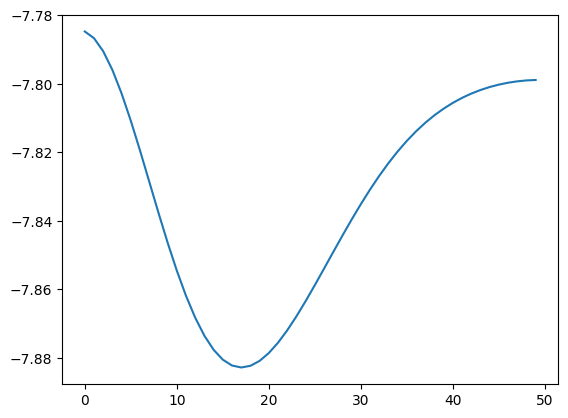

In [25]:
chebyfit = np.polynomial.Chebyshev.fit(r_array, cavity_free_E_array_LiH[:,0], 4)
print(chebyfit)
plt.plot(cavity_free_E_array_LiH[:,0])
plt.show

In [ ]:
# template for the z-matrix so we can scan through bond lengths
mol_tmpl_H2 = """
H
H 1 **R**
symmetry c1
"""


# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el_H2 = 4

# array for energies for LiH outside cavity
cavity_free_E_array_H2 = np.zeros((N_R, N_el_H2))

# array  for energies inside the cavity
cavity_E_array_H2 = np.zeros((N_R, N_el_H2))

r_idx_H2 = 0
for r in r_array:
    mol_str_H2 = mol_tmpl_H2.replace("**R**", str(r))
    mol_H2 = psi4.geometry(mol_str_H2)
    print(mol_str_H2)
    
    # call psi4 RHF
    scf_e, wfn_H2 = psi4.energy('SCF/sto-3g', return_wfn=True)
    
    # call psi4 FCI
    fci_energy_H2 = psi4.energy('fci/sto-3g',ref_wfn=wfn_H2)
    
    # H2 no cavity
    H2 = PFHamiltonianGenerator(mol_str_H2, options_dict, cavity_free_dict)

    # check to make sure PFHamiltonian cavity-free FCI ground-state agrees with psi4
    assert np.isclose(H2.CIeigs[0], fci_energy_H2)
    
    # H2 with cavity
    H2_cav = PFHamiltonianGenerator(mol_str_H2, options_dict, cavity_dict)
    cavity_free_E_array_H2[r_idx_H2,:] = H2.CIeigs[:N_el_H2]
    cavity_E_array_H2[r_idx_H2,:] = H2_cav.CIeigs[:N_el_H2]
    r_idx_H2 += 1
    
    

In [ ]:
# z-matrix for H2
mol_str = """
H
H 1 0.74
symmetry c1
"""

# options dictionary for the psi4 calculation
options_dict0 = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# let's run a psi4 geometry optimization to get the optimal geometry

# set the options
psi4.set_options(options_dict0)

# first set the coordinates in init_string as the molecule's geometry 
mol0_H2 = psi4.geometry(mol_str_H2)

# now capture the psi4 geometry data with the guess coordinates
init_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_H2)

# run the geometry optimization
psi4.optimize("HF")

guess_geometry_H2 = mol0_H2.geometry()

guess_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol0_H2)


In [ ]:
# options dictionary for the psi4 calculation
options_dict = {'basis': 'sto-3g',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-8,
               'd_convergence' : 1e-7
               }

# set the options
psi4.set_options(options_dict)

# first set the coordinates in guess_string as the molecule's geometry 
mol_H2 = psi4.geometry(guess_string_H2)

# now capture the psi4 geometry data with the guess coordinates
guess_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol_H2)

# run the geometry optimization
psi4.optimize("HF")

opt_geometry_H2 = mol_H2.geometry()

# capture the psi4 geometry data from the optimization
opt_geometry_string_H2 = psi4.core.Molecule.create_psi4_string_from_molecule(mol_H2)

# run excited-state calculations - get first 5 excited states
n_states = 1

# run psi4 TDSCF at same level of theory as geometry optimization
psi4_rhf_e, wfn_H2 = psi4.frequency("HF/sto-3g", return_wfn=True, molecule=mol_H2,maxiter=50)



## Calculation of the Huang-Rhys Factor
Huang Rhys factor can be calculated by both

$$ S = 1/2(\Delta x / x_0)^2 \tag{Turner}$$

from the mode anharmonicity paper

and 

$$ S = \frac{m\omega_{vib} \Delta x^2}{2 \hbar} \tag{Hsu}$$

from the polaritonic Huang-Rhys factor paper

In [27]:
from scipy import constants
m_H = constants.m_p + constants.m_e 
print(m_H * constants.N_A * 1000)
m_Li = 3 * constants.m_p + 4 * constants.m_n + 3 * constants.m_e
# Constants and Variables
x_0 = wfn_LiH.frequency_analysis["Xtp0"].data[5]
k_SI = wfn_LiH.frequency_analysis["k"].data[5] * 10 ** 2
print(x_0)
min_S1_loc = np.argmin(cavity_free_E_array_LiH[:,1])
min_S0_loc = np.argmin(cavity_free_E_array_LiH[:,0])
print(f'Min on S0 is {r_array[min_S0_loc]}')
print(f'Min on S1 is {r_array[min_S1_loc]}')
delta_au = (r_array[min_S1_loc] - r_array[min_S0_loc]) / psi4.constants.bohr2angstroms
delta_m = (r_array[min_S1_loc] - r_array[min_S0_loc]) * 10 ** (-10)
mu_kg = (m_H * m_Li) / (m_H + m_Li)
omega_vib = np.sqrt(k_SI / mu_kg)
h_bar = constants.hbar
r_eq = r_array[min_S0_loc]

# Turner
S_Turner = 0.5 * (delta_au / x_0) ** 2

# Hsu
S_Hsu = mu_kg * omega_vib * delta_m ** 2 / (2 * h_bar)

print(S_Turner)
print(S_Hsu)

1.0078250461811888
0.25176965409112306
Min on S0 is 1.5460095002604533
Min on S1 is 2.999506560365732
59.509909215984344
52.58905918603806


In [ ]:
D_e_Hartree = cavity_free_E_array_LiH[49,0] - cavity_free_E_array_LiH[min_S0_loc,0] 
D_e = 0.09848201074825358
D_e_J = D_e_Hartree * 4.3597 * 10 ** (-18)
alpha_inv_m = np.sqrt(k_SI / (2 * D_e_J))
alpha_inv_Angs = alpha_inv_m * 10 ** (-10)
kappa = 2 * D_e_Hartree * alpha_inv_Angs ** 2
g = -6 * D_e_Hartree * alpha_inv_Angs ** 3
h = 14 * D_e_Hartree * alpha_inv_Angs ** 4

In [ ]:
V_r = D_e_Hartree * (1 - np.exp(-alpha_inv_Angs * (r_array - r_eq))) ** 2

V_r_spline = interpolate.UnivariateSpline(r_array, V_r, k=4)

# now define the expansion coefficients to expand the Morse potential as a polynomial
# harmonic
f_spline = V_r_spline.derivative()
k_spline = f_spline.derivative()
g_spline = k_spline.derivative()
h_spline = g_spline.derivative()

k_num = k_spline(r_eq)
g_num = g_spline(r_eq)
h_num = h_spline(r_eq)



V_H = 1/2 * k_num * (r_array - r_eq) ** 2

# cubic
#g = -6 * D_e * alpha ** 3

V_C = V_H + 1/6 * g_num * (r_array - r_eq) ** 3

# quartic 
#h = 14 * D_e * alpha ** 4

V_Q = V_H + V_C + 1/24 * h_num * (r_array - r_eq) ** 4


plt.plot(r_array, V_r, 'red')
#plt.plot(r_array, V_r_spline(r), 'blue')
#plt.plot(r, V_C, 'green')
plt.plot(r_array, V_Q, 'purple')
#plt.xlim(0.75 * r_eq, 1.5 * r_eq)
#plt.ylim(0, 2e-18)
plt.show()
print(V_Q)

In [ ]:
def quartic_morse(r, De, k, re, g, h):
    return (1 / 2) * k * (r - re) ** 2 + (1 / 6) * g * (r - re) ** 3 + (1 / 24) * h * (r - re) ** 4
    #return De * (1 - np.exp(-k * (r - re))) ** 2 + g * (r - re) ** 3 + h * (r - re) ** 4

# Initial parameter guesses
initial_guess = [D_e, kappa, r_eq, g, h]

# Perform the curve fit
fit_params, covariance = curve_fit(quartic_morse, r_array, cavity_free_E_array_LiH[:,0], p0=initial_guess, maxfev=10000)

# Extract the optimized parameters
De_fit, k_fit, re_fit, g_fit, h_fit = fit_params

V_fit = quartic_morse(r_array, De_fit, k_fit, re_fit, g_fit, h_fit)

print(V_fit)

First plot the ground-state potential energy surfaces for LiH inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

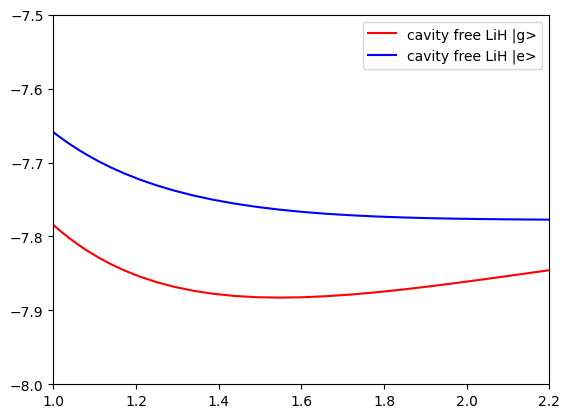

In [26]:
plt.plot(r_array, cavity_free_E_array_LiH[:,0], 'r-', label='cavity free LiH |g>')
plt.plot(r_array, cavity_free_E_array_LiH[:,1], 'b-', label='cavity free LiH |e>')
#plt.plot(r_array, V_fit, label='fit')
plt.xlim(1.0, 2.2)
plt.ylim(-8.0, -7.5)
plt.legend()
plt.show()



In [ ]:
plt.plot(r_array, cavity_free_E_array_H2[:,0], 'r-', label='cavity free H2 |g>')
plt.plot(r_array, cavity_free_E_array_H2[:,1], 'b-', label='cavity free H2 |e>')
plt.legend()
plt.show()

Next plot the ground state surface shifted by the cavity energy and the first excited state surface of 
LiH outside the cavity along with the lower- and upper-polariton surfaces from LiH inside the cavity.
Note that lower polariton surface intersects with another surface for the molecule in the cavity (see the crossing of the red and green curves around r = 1.5 Angstroms); the polariton surface is smooth, so we should really re-sort the eigenvalues around this point. Ruby has some experience doing this. 

In [ ]:
plt.plot(r_array, cavity_free_E_array_LiH[:,0]+0.12086, label='cavity free |g>+$\omega$')
plt.plot(r_array, cavity_free_E_array_LiH[:,1], label='cavity free |e>')
plt.plot(r_array, cavity_E_array_LiH[:,1], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_LiH[:,2], label='cavity |LP>')
plt.plot(r_array, cavity_E_array_LiH[:,3], label='cavity |UP>')
plt.xlim(1.0, 2.2)
plt.ylim(-7.78, -7.63)
plt.legend()
plt.show()